In [506]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, models

In [507]:
import sys
print(str(sys.version_info))

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)


In [508]:
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Load data from csv 

In [509]:
RUN = "run2"

In [510]:
data = pd.read_csv(f"{RUN}/chat_features1.csv")
data.columns = [
    "channel",
    "duration",
    "start_timestamp",
    "message_count", 
    "mod_message_count", 
    "sub_message_count",
    "turbo_message_count",
    "self_toxic_count",
    "self_positive_count",
    "hopped_toxic_count",
    "hopped_positive_count"
]

In [511]:
# data2 = pd.read_csv(f"{RUN}/chat_features2.csv")
# datas = [data1, data2]
# for data in datas:
#     data.columns = [
#         "channel",
#         "duration",
#         "start_timestamp",
#         "message_count", 
#         "mod_message_count", 
#         "sub_message_count",
#         "turbo_message_count",
#         "self_toxic_count",
#         "self_positive_count",
#         "hopped_toxic_count",
#         "hopped_positive_count"
#     ]
# data = pd.concat([data1, data2])

In [512]:
data

,channel,duration,start_timestamp,message_count,mod_message_count,sub_message_count,turbo_message_count,self_toxic_count,self_positive_count,hopped_toxic_count,hopped_positive_count
0,heydani,3600,1.602568e+09,527,115,369,1,101,116,0,2
1,dagamer2323,3600,1.602568e+09,2523,251,1236,1,385,433,0,0
2,nudah,3600,1.602568e+09,606,91,520,0,156,91,0,2
3,tinakitten,3600,1.602568e+09,3521,110,719,9,426,650,14,21
4,cjshiz,3600,1.602568e+09,59,3,53,0,7,27,2,9
...,...,...,...,...,...,...,...,...,...,...,...
87359,slicklithium,3600,1.604991e+09,193,42,42,0,21,75,0,0
87360,tangle_night,3600,1.604991e+09,32,17,0,0,4,11,0,0
87361,bombhor,3600,1.604991e+09,232,93,174,0,19,68,0,4
87362,blu3hawk,3600,1.604991e+09,73,25,28,0,5,21,0,0


In [513]:
data = data.dropna(axis=0)

data["month"] = data.apply(lambda row: datetime.fromtimestamp(row["start_timestamp"]).month, axis=1)
data["day"] = data.apply(lambda row: datetime.fromtimestamp(row["start_timestamp"]).day, axis=1)
data["hour"] = data.apply(lambda row: datetime.fromtimestamp(row["start_timestamp"]).hour, axis=1)

In [514]:
X = data.drop(labels=["start_timestamp", "duration", "channel", "hopped_toxic_count", "hopped_positive_count"], axis=1)
y = data["hopped_toxic_count"]

In [515]:
print(X.shape)
X

(87364, 9)


,message_count,mod_message_count,sub_message_count,turbo_message_count,self_toxic_count,self_positive_count,month,day,hour
0,527,115,369,1,101,116,10,13,1
1,2523,251,1236,1,385,433,10,13,1
2,606,91,520,0,156,91,10,13,1
3,3521,110,719,9,426,650,10,13,1
4,59,3,53,0,7,27,10,13,1
...,...,...,...,...,...,...,...,...,...
87359,193,42,42,0,21,75,11,10,1
87360,32,17,0,0,4,11,11,10,1
87361,232,93,174,0,19,68,11,10,1
87362,73,25,28,0,5,21,11,10,1


In [516]:
y

0         0
1         0
2         0
3        14
4         2
         ..
87359     0
87360     0
87361     0
87362     0
87363     0
Name: hopped_toxic_count, Length: 87364, dtype: int64

In [517]:
print(f"{len(X)} == {len(y)}")

87364 == 87364


## Most toxic channels

### Mean toxic count

In [518]:
data.groupby(["channel"]).mean().sort_values("hopped_toxic_count", ascending=False)["hopped_toxic_count"].head(30)

channel
aoc                 92.000000
jawsh               72.000000
ilhan               66.000000
tommyinnit          65.500000
wilbursoot          56.000000
xqcow               47.367347
hollow_tones        41.333333
eajparkofficial     40.041667
tubbo               38.050000
badboyhaloislive    37.000000
quackityhq          30.571429
karljacobs          28.928571
sykkuno             27.870370
trainwreckstv       26.447619
w2s                 22.857143
lospollostv         22.666667
symfuhny            21.555556
adinross            19.166667
shnaggyhose         19.000000
pancakerzs          19.000000
nihachu             19.000000
yourragegaming      18.105263
clix                17.000000
georgenotfound      17.000000
xlie                16.833333
hasanabi            16.277778
lilypichu           16.250000
jacksepticeye       16.105263
crankgameplays      16.100000
5uppp               16.020690
Name: hopped_toxic_count, dtype: float64

### Max toxic count

In [519]:
data.groupby(["channel"]).max().sort_values("hopped_toxic_count", ascending=False)["hopped_toxic_count"].head(30)

channel
xqcow               360
bazzagazza          244
eajparkofficial     242
tubbo               153
aoc                 148
hasanabi            142
tommyinnit          135
trainwreckstv       133
itshafu             107
crayator            106
wilbursoot           94
moistcr1tikal        91
sykkuno              88
crankgameplays       78
ilhan                77
5uppp                75
jawsh                72
karljacobs           71
callux               69
clockdistrict        65
punz                 65
badboyhaloislive     65
hirokaisen           58
ludwig               55
pokimane             55
hollow_tones         55
itssliker            54
m0xyy                53
deansocool           52
yourragegaming       52
Name: hopped_toxic_count, dtype: int64

## Grouped X

In [520]:
grouped = data.groupby(["channel"]).mean()
grouped

,duration,start_timestamp,message_count,mod_message_count,sub_message_count,turbo_message_count,self_toxic_count,self_positive_count,hopped_toxic_count,hopped_positive_count,month,day,hour
channel,,,,,,,,,,,,,
0die,3600.0,1.604153e+09,80.600000,19.400000,41.500000,0.0,12.500000,24.800000,0.000000,0.000000,10.800000,5.700000,20.400000
0h0khaha,3600.0,1.604795e+09,53.000000,53.000000,26.000000,0.0,26.000000,0.000000,0.000000,0.000000,11.000000,7.000000,19.000000
0megasage,3600.0,1.604327e+09,38.000000,0.000000,2.000000,0.0,3.000000,5.000000,0.000000,2.000000,11.000000,2.000000,9.000000
0neaway,3600.0,1.603309e+09,144.333333,50.000000,3.333333,0.0,28.000000,31.666667,0.000000,0.000000,10.000000,21.333333,7.000000
0onionrings,3600.0,1.604135e+09,237.000000,199.000000,26.500000,0.0,26.500000,3.000000,0.000000,0.000000,10.500000,15.000000,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyonik_,3600.0,1.603428e+09,131.818182,0.818182,30.909091,0.0,22.000000,34.545455,0.545455,0.636364,10.000000,22.363636,15.545455
zyyes,3600.0,1.603196e+09,1401.750000,124.000000,861.250000,0.0,89.250000,588.250000,0.000000,2.250000,10.000000,20.250000,1.500000
zyzerr,3600.0,1.604161e+09,61.333333,16.333333,21.333333,0.0,4.333333,17.333333,0.000000,0.000000,10.666667,10.333333,11.000000


In [521]:
data = grouped.dropna(axis=0)

X = data.drop(labels=[
    "start_timestamp", 
    "duration", 
    "hopped_toxic_count", 
    "hopped_positive_count",
    "month",
    "day"
], axis=1)
y = data["hopped_toxic_count"]

print(X.shape)
print(y.shape)

(15785, 7)
(15785,)


## Linear regression

In [522]:
model = linear_model.LinearRegression()
model.fit(X, y)

predicted = model.predict(X)
mse = metrics.mean_squared_error(y, predicted)
print(mse)

r2_score = metrics.r2_score(y_test, test_predicted)
print(r2_score)


1.45335020367913
-0.8456645296266783


/home/goatgoose/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


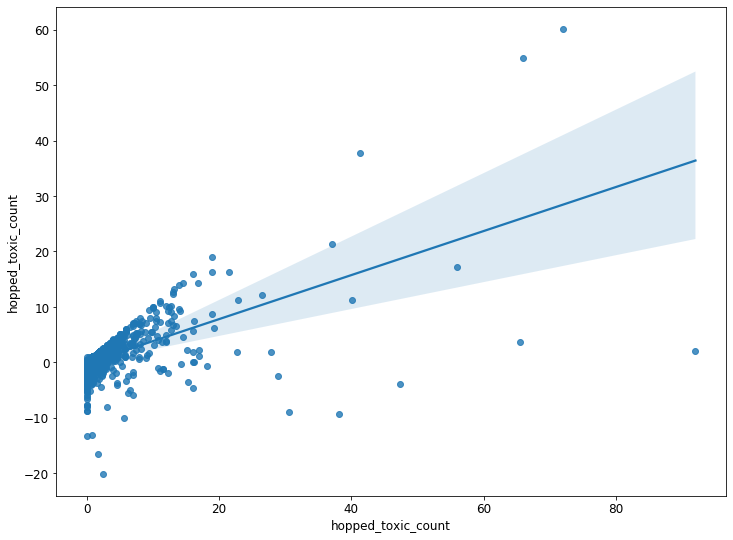

In [523]:
residuals = y - np.array(predicted)
ax = sns.regplot(y, residuals)

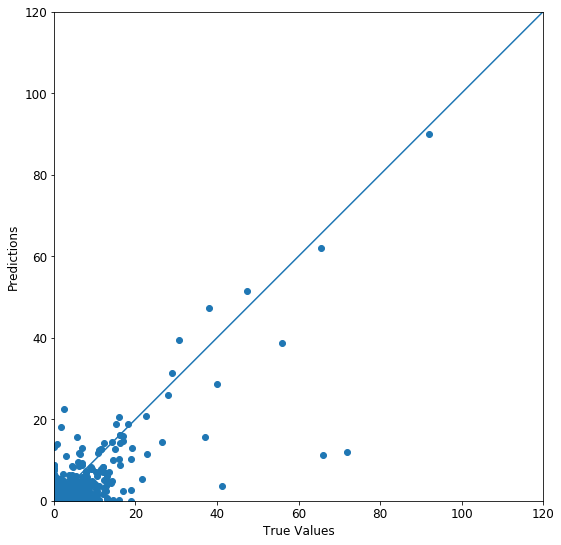

In [524]:
test_predictions = model.predict(X).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y, predicted)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 120]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## NN Model

In [525]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [526]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12628, 7) (12628,)
(3157, 7) (3157,)


In [548]:
dense_count = 128

model = models.Sequential([
    layers.Dense(dense_count),
    layers.Activation('relu'),
    layers.Dense(dense_count),
    layers.Activation('relu'),
    layers.Dense(dense_count),
    layers.Activation('relu'),
    layers.Dense(1)
])

adagrad = optimizers.Adagrad()
adam = optimizers.Adam()

model.compile(optimizer=adam,
              loss=tf.keras.losses.mean_squared_error,
              metrics=[tf.keras.metrics.MeanSquaredError()])

fit = model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=50, batch_size=128, validation_split=0.1)

Train on 11365 samples, validate on 1263 samples
Epoch 1/50
11365/11365 [==============================] - 0s 36us/sample - loss: 315.2064 - mean_squared_error: 315.2065 - val_loss: 24.0666 - val_mean_squared_error: 24.0666
Epoch 2/50
11365/11365 [==============================] - 0s 12us/sample - loss: 128.7080 - mean_squared_error: 128.7080 - val_loss: 2859.6983 - val_mean_squared_error: 2859.6982
Epoch 3/50
11365/11365 [==============================] - 0s 13us/sample - loss: 1910.2190 - mean_squared_error: 1910.2191 - val_loss: 59.2198 - val_mean_squared_error: 59.2198
Epoch 4/50
11365/11365 [==============================] - 0s 13us/sample - loss: 4.3518 - mean_squared_error: 4.3518 - val_loss: 2.5922 - val_mean_squared_error: 2.5922
Epoch 5/50
11365/11365 [==============================] - 0s 13us/sample - loss: 15.3034 - mean_squared_error: 15.3034 - val_loss: 5.6319 - val_mean_squared_error: 5.6319
Epoch 6/50
11365/11365 [==============================] - 0s 13us/sample - loss:

Epoch 49/50
11365/11365 [==============================] - 0s 14us/sample - loss: 1.3411 - mean_squared_error: 1.3411 - val_loss: 1.9794 - val_mean_squared_error: 1.9794
Epoch 50/50
11365/11365 [==============================] - 0s 20us/sample - loss: 1.4866 - mean_squared_error: 1.4866 - val_loss: 1.1744 - val_mean_squared_error: 1.1744


In [549]:
test_predictions = model.predict(X_test).flatten()
train_predictions = model.predict(X_train).flatten()

In [550]:
r2_score = metrics.r2_score(y_test, test_predictions)
print(r2_score)

0.4118464439045083


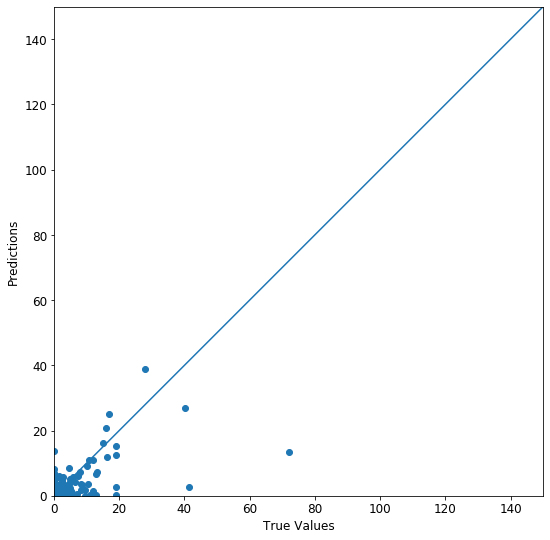

In [551]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 150]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

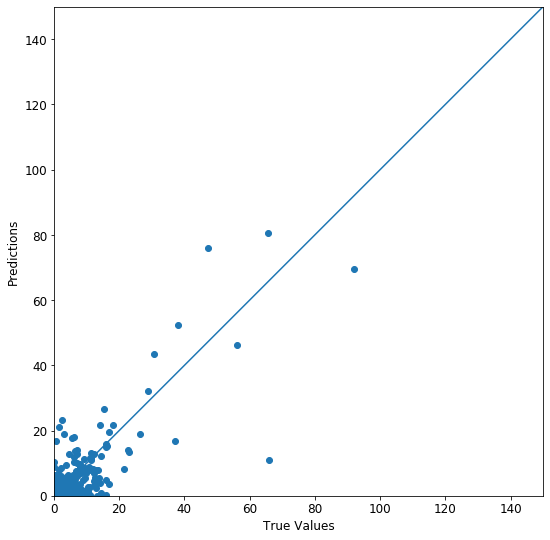

In [552]:
a = plt.axes(aspect='equal')
plt.scatter(y_train, train_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 150]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)